In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt


In [13]:
df = pd.read_csv('cardio_train.csv', sep = ';')
print(df['gender'].value_counts()) # 1 - women, 2 - men
print(df.head())

gender
1    45530
2    24470
Name: count, dtype: int64
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


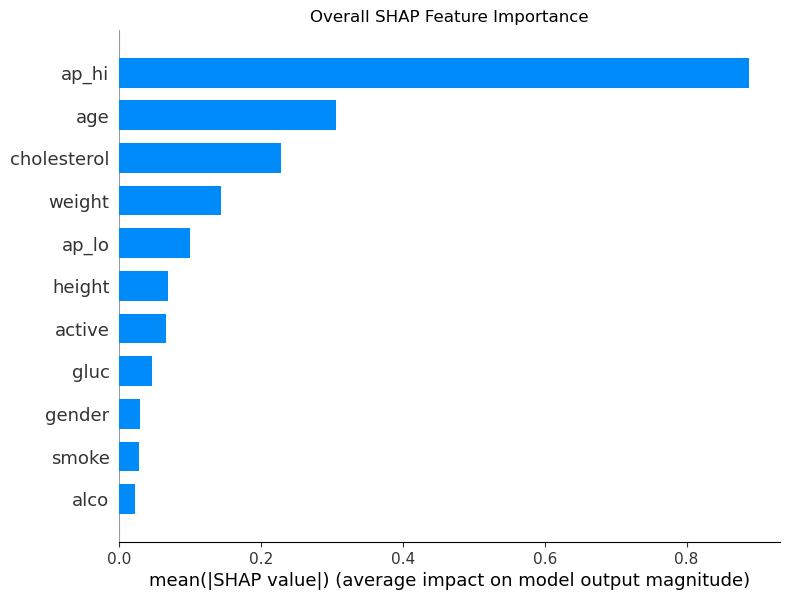

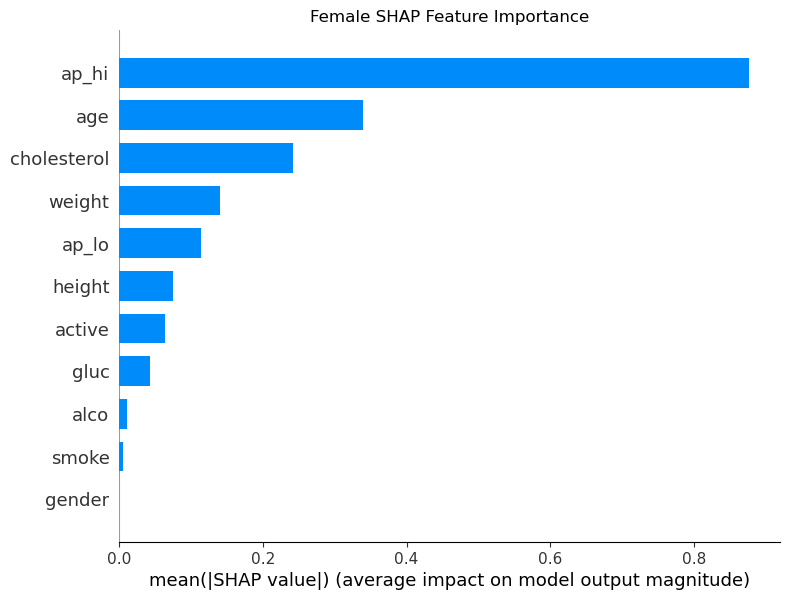

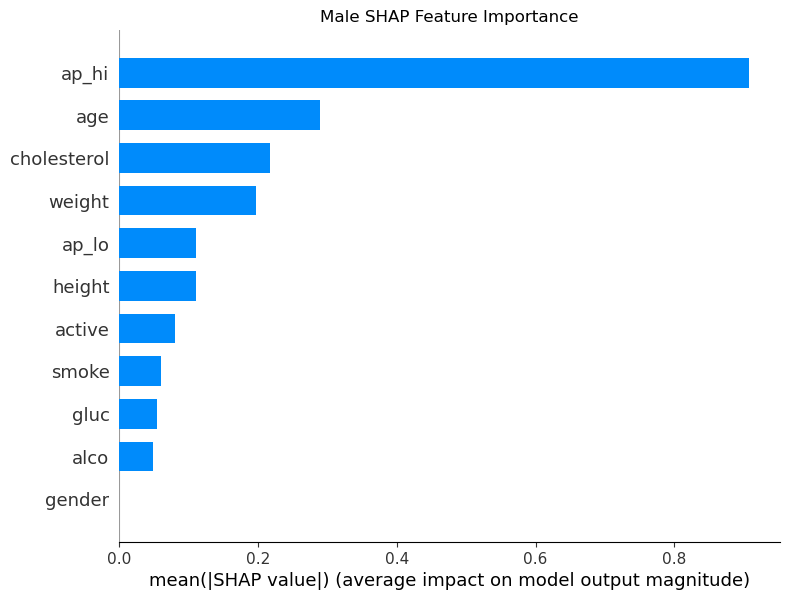

Overall Top Features:
[('ap_hi', 0.8874202), ('age', 0.3051957), ('cholesterol', 0.22802782), ('weight', 0.1433473), ('ap_lo', 0.10004836), ('height', 0.06826501), ('active', 0.06547116), ('gluc', 0.04618748), ('gender', 0.028677287), ('smoke', 0.027770441)]

Female Top Features:
[('ap_hi', 0.8761584), ('age', 0.3394441), ('cholesterol', 0.24188009), ('weight', 0.14028037), ('ap_lo', 0.11435043), ('height', 0.07541238), ('active', 0.06336636), ('gluc', 0.042550802), ('alco', 0.010790071), ('smoke', 0.005132272)]

Male Top Features:
[('ap_hi', 0.90688825), ('age', 0.2886601), ('cholesterol', 0.21749657), ('weight', 0.19745694), ('ap_lo', 0.11132542), ('height', 0.11068261), ('active', 0.08068734), ('smoke', 0.06065869), ('gluc', 0.05491214), ('alco', 0.048416395)]


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# ----------------------------
# 1. Load Data & Preprocessing
# ----------------------------
# Read the dataset (adjust the path as needed)
df = pd.read_csv('cardio_train.csv', sep=';')

# Drop the ID column as it is not a predictor
df.drop(columns=['id'], inplace=True)

# Define target and features
target = 'cardio'
features = [col for col in df.columns if col != target]

# Identify numerical columns for scaling (adjust if needed)
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Instantiate scaler and scale the numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# ----------------------------
# 2. Split the Dataset by Gender
# ----------------------------
# According to the dataset: 1 = female, 2 = male
df_female = df[df['gender'] == 1].copy()
df_male = df[df['gender'] == 2].copy()

def preprocess_subset(df_subset, scaler, num_cols, target):
    """
    Preprocess a subset of the data:
    - Ensure numeric features are scaled using the already fitted scaler.
    - Separate predictors and target.
    """
    df_subset = df_subset.copy()
    # (ID already dropped in the main df)
    df_subset[num_cols] = scaler.transform(df_subset[num_cols])
    X_subset = df_subset.drop(columns=[target])
    y_subset = df_subset[target]
    return X_subset, y_subset

# Get features and labels for each subset
X_overall = df.drop(columns=[target])
y_overall = df[target]

X_female, y_female = preprocess_subset(df_female, scaler, num_cols, target)
X_male, y_male = preprocess_subset(df_male, scaler, num_cols, target)

# ----------------------------
# 3. Train Models
# ----------------------------
def train_model(X, y):
    """
    Train an XGBoost classifier.
    """
    model = xgb.XGBClassifier(eval_metric='logloss')
    model.fit(X, y)
    return model

# Train on overall, female-only, and male-only data
model_overall = train_model(X_overall, y_overall)
model_female = train_model(X_female, y_female)
model_male = train_model(X_male, y_male)

# ----------------------------
# 4. SHAP Feature Importance Analysis
# ----------------------------
# Initialize SHAP explainers
explainer_overall = shap.Explainer(model_overall)
shap_values_overall = explainer_overall(X_overall)

explainer_female = shap.Explainer(model_female)
shap_values_female = explainer_female(X_female)

explainer_male = shap.Explainer(model_male)
shap_values_male = explainer_male(X_male)

# Plot SHAP summary (bar plot) for each group
plt.figure()
shap.summary_plot(shap_values_overall, X_overall, plot_type="bar", show=False)
plt.title('Overall SHAP Feature Importance')
plt.show()

plt.figure()
shap.summary_plot(shap_values_female, X_female, plot_type="bar", show=False)
plt.title('Female SHAP Feature Importance')
plt.show()

plt.figure()
shap.summary_plot(shap_values_male, X_male, plot_type="bar", show=False)
plt.title('Male SHAP Feature Importance')
plt.show()

# ----------------------------
# 5. Extract and Report Top Features
# ----------------------------
def get_top_features(shap_values, X, top_n=10):
    """
    Compute the mean absolute SHAP value for each feature and return the top features.
    """
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    feature_importance = dict(zip(X.columns, mean_shap))
    top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_features

print("Overall Top Features:")
print(get_top_features(shap_values_overall, X_overall))

print("\nFemale Top Features:")
print(get_top_features(shap_values_female, X_female))

print("\nMale Top Features:")
print(get_top_features(shap_values_male, X_male))


Performance for Female Patients (Original Data):
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      5699
           1       0.76      0.68      0.72      5688

    accuracy                           0.73     11387
   macro avg       0.73      0.73      0.73     11387
weighted avg       0.73      0.73      0.73     11387

Performance for Male Patients (Original Data):
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      3056
           1       0.75      0.72      0.73      3057

    accuracy                           0.74      6113
   macro avg       0.74      0.74      0.74      6113
weighted avg       0.74      0.74      0.74      6113

Fairness Metrics by Gender:
             TPR       FPR
gender                    
1       0.682138  0.220214
2       0.715080  0.236257


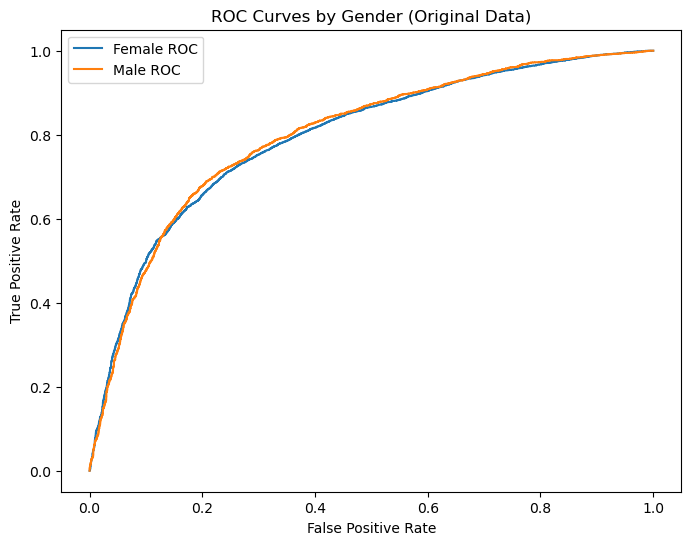

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate

# ----------------------------
# 1. Load Data & Preprocessing
# ----------------------------
df = pd.read_csv('cardio_train.csv', sep=';')

# Drop the ID column as it is not a predictor
df.drop(columns=['id'], inplace=True)

# Define target and features
target = 'cardio'
features = [col for col in df.columns if col != target]

# Identify numerical columns for scaling
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Instantiate scaler and scale the numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# ----------------------------
# 2. Split the Dataset by Gender for Separate Analysis (if needed)
# ----------------------------
# According to the dataset: 1 = female, 2 = male
df_female = df[df['gender'] == 1].copy()
df_male = df[df['gender'] == 2].copy()

def preprocess_subset(df_subset, scaler, num_cols, target):
    """
    Preprocess a subset of the data:
    - Scale numeric features using the already fitted scaler.
    - Separate predictors and target.
    """
    df_subset = df_subset.copy()
    df_subset[num_cols] = scaler.transform(df_subset[num_cols])
    X_subset = df_subset.drop(columns=[target])
    y_subset = df_subset[target]
    return X_subset, y_subset

X_overall = df.drop(columns=[target])
y_overall = df[target]

X_female, y_female = preprocess_subset(df_female, scaler, num_cols, target)
X_male, y_male = preprocess_subset(df_male, scaler, num_cols, target)

# ----------------------------
# 3. Evaluate on the Original (Imbalanced) Dataset
# ----------------------------
# Split the original dataset with stratification by target
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_overall, y_overall, test_size=0.25, random_state=0, stratify=y_overall)

# Train an XGBoost classifier on the original unbalanced data
model_RF_orig = xgb.XGBClassifier(eval_metric='logloss', random_state=0)
model_RF_orig.fit(X_train_orig, y_train_orig)

# Overall performance
y_pred_orig = model_RF_orig.predict(X_test_orig)
# print("Overall Performance on Original Data:")
# print(classification_report(y_test_orig, y_pred_orig))

# ----------------------------
# 4. Evaluate Performance by Gender
# ----------------------------
# Separate the test set by gender
X_test_orig_female = X_test_orig[X_test_orig['gender'] == 1]
y_test_orig_female = y_test_orig[X_test_orig['gender'] == 1]
X_test_orig_male = X_test_orig[X_test_orig['gender'] == 2]
y_test_orig_male = y_test_orig[X_test_orig['gender'] == 2]

y_pred_orig_female = model_RF_orig.predict(X_test_orig_female)
y_pred_orig_male = model_RF_orig.predict(X_test_orig_male)

print("Performance for Female Patients (Original Data):")
print(classification_report(y_test_orig_female, y_pred_orig_female))
print("Performance for Male Patients (Original Data):")
print(classification_report(y_test_orig_male, y_pred_orig_male))

# ----------------------------
# 5. Fairness Metrics Using Fairlearn
# ----------------------------
# Calculate TPR and FPR for each gender group
metrics = {'TPR': true_positive_rate, 'FPR': false_positive_rate}
mf = MetricFrame(metrics=metrics,
                 y_true=y_test_orig,
                 y_pred=y_pred_orig,
                 sensitive_features=X_test_orig['gender'])
print("Fairness Metrics by Gender:")
print(mf.by_group)

# ----------------------------
# 6. ROC Curves by Gender
# ----------------------------
# Obtain predicted probabilities for the positive class
y_prob_female = model_RF_orig.predict_proba(X_test_orig_female)[:, 1]
y_prob_male = model_RF_orig.predict_proba(X_test_orig_male)[:, 1]

# Compute ROC curves for each gender
fpr_f, tpr_f, _ = roc_curve(y_test_orig_female, y_prob_female)
fpr_m, tpr_m, _ = roc_curve(y_test_orig_male, y_prob_male)

plt.figure(figsize=(8, 6))
plt.plot(fpr_f, tpr_f, label='Female ROC')
plt.plot(fpr_m, tpr_m, label='Male ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Gender (Original Data)')
plt.legend()
plt.show()
